In [74]:
import torch
from pathlib import Path
from pydicom import dcmread
from PIL import Image
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# TO DO: 



###### Use Grad-CAM or heatmap visualization to interpret model focus.

###### Implement data augmentation early to reduce overfitting.

###### Downsample images to 224×224 or 256×256 to save resources without performance loss.



###### Use sklearn train test split to split the data into train and validation set

###### Also address the class imbalance

###### More EDA on the Data---graphs and tables to show the data stuff and training decision made based on that

###### Image Augmentation to increase the data samples



###### Train the model again after completing all of the above steps for up to 100 epochs
###### In the mean time also look for more powerful computer to train the model on

### Load the label file with bbox labels and detail_class_info label file 

In [77]:
# File path of the labels from the working data and convert the csv file into a pandas DataFrame

label_file_path = 'data/pneumonia_dataset/stage_2_train_labels.csv'
label_file_df = pd.read_csv(label_file_path)

class_info_df = pd.read_csv('data/pneumonia_dataset/stage_2_detailed_class_info.csv')

In [ ]:
# merge the two dataframe on the basis of `patientId`
df = pd.merge(label_file_df, class_info_df, left_on='patientId', right_on='patientId')

In [88]:
df.sample(10)

,patientId,x,y,width,height,Target,class
29038,cec94a19-38c3-4848-819f-7899f0dcdeff,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
18680,930d83dd-cd4c-4968-a94e-581903c2cd76,NaN,NaN,NaN,NaN,0,Normal
17485,8b7729cf-8961-452c-8b03-926516ac5c90,223.0,356.0,288.0,385.0,1,Lung Opacity
17838,8da6abd4-8940-4696-bc43-6f0891cb7493,592.0,560.0,320.0,464.0,1,Lung Opacity
11820,663c34ed-9fa8-436b-8c35-88302307fa5e,NaN,NaN,NaN,NaN,0,Normal
16536,85a77a2c-9fb8-4ceb-af2b-4de716d4d366,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
11017,6050f5be-e861-451b-80c4-0b79c9eaf9cc,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
35825,ffa424d2-6e6b-4eed-93ab-7551e8941215,699.0,412.0,162.0,214.0,1,Lung Opacity
30412,d9245b95-1261-4dd6-88a8-2c9a69578b0e,213.0,259.0,168.0,401.0,1,Lung Opacity
335,06250f9d-5ad9-44ca-9283-dbf787e2ad22,55.0,228.0,310.0,546.0,1,Lung Opacity


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37629 entries, 0 to 37628
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  37629 non-null  object 
 1   x          16957 non-null  float64
 2   y          16957 non-null  float64
 3   width      16957 non-null  float64
 4   height     16957 non-null  float64
 5   Target     37629 non-null  int64  
 6   class      37629 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 2.0+ MB


### Handle Missing Data
The `0` or `no pneumonia` class has no bbox data so we only need to handle missing data for the `1` or `pneumonia` class

In [96]:
df

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
...,...,...,...,...,...,...,...
37624,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,Normal
37625,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity
37626,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity
37627,c1f7889a-9ea9-4acb-b64c-b737c929599a,233.0,424.0,201.0,356.0,1,Lung Opacity


In [100]:
# The `x`, `y`, `width` and `height` columns for Target 0 are excepted to have missing value indicating no bbox
missing_data = df.isna().sum()
print(f'Number of missing values per columns:\n{missing_data}')

Number of missing values per columns:
patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
class            0
dtype: int64


In [101]:
# Check missing data exclusisvley for Target class 1
present_df = df[df.Target == 1]
missing_data_pres = present_df.isna().sum()
print(f'Number of missing values per columns:\n{missing_data_pres}')

Number of missing values per columns:
patientId    0
x            0
y            0
width        0
height       0
Target       0
class        0
dtype: int64


### Check the class Distribution in the data

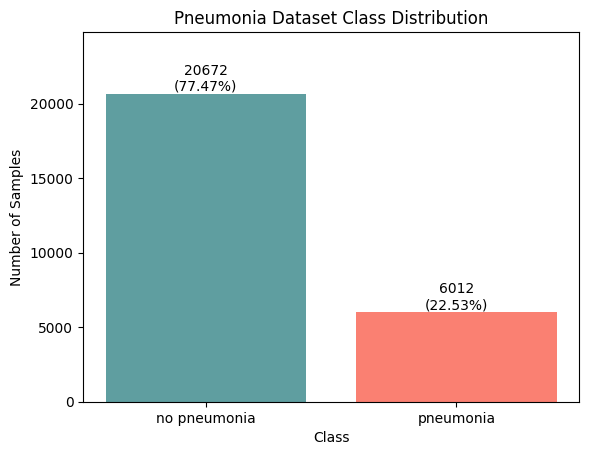

In [102]:
# Number of Data samples with pneumonia and without pneumonia

counts = df.drop_duplicates('patientId')['Target'].value_counts()

# num_no_pneumonia = counts[0]
# num_pneumonia = counts[1]

data_class = {
    'no pneumonia': int(counts.get(0, 0)),
    'pneumonia': int(counts.get(1, 0))
}

total = sum(data_class.values())


bars = plt.bar(data_class.keys(), data_class.values(), color=['cadetblue', 'salmon'])
plt.bar_label(bars, labels=[f"{value}\n({value/total*100:.2f}%)" for value in data_class.values()])
plt.ylim(0, 1.2*max(data_class.values()))
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Pneumonia Dataset Class Distribution')
plt.show()

In [110]:
# Create a dictionary with all the classes and their corresponding value(occurance in the label)
count = df.drop_duplicates('patientId')['class'].value_counts()

data_class_detail = count.keys()

data_num_obj = {}


for x in range(len(count)):
    entry = {data_class_detail[x]: count.iloc[x].item()}
    data_num_obj.update(entry)

data_num_obj

{'No Lung Opacity / Not Normal': 11821, 'Normal': 8851, 'Lung Opacity': 6012}

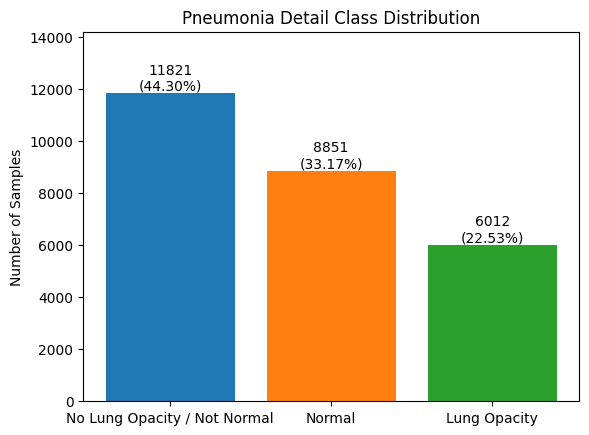

In [111]:
color = sns.color_palette('tab10', n_colors=len(data_num_obj))

total = sum(count.values).item()

bar = plt.bar(data_num_obj.keys(), data_num_obj.values(), color=color)

plt.bar_label(bar, labels=[f'{values}\n({(values/total)*100:.2f}%)' for values in data_num_obj.values()])
plt.ylim(0, 1.2*max(data_num_obj.values()))
# plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Pneumonia Detail Class Distribution')
plt.show()

RSNA Pneumonia Detection - (3-Class Label Explanation):
* 'Lung Opacity'                 --> Pneumonia or similar lung opacity (positive case)
* 'Normal'                       --> Completely normal chest X-ray (no abnormal findings)
* 'No Lung Opacity / Not Normal' --> Abnormal chest X-ray, but NOT pneumonia (e.g., cardiomegaly, effusion, etc.)

This labeling helps distinguish pneumonia from both normal and other non-pneumonia abnormalities.

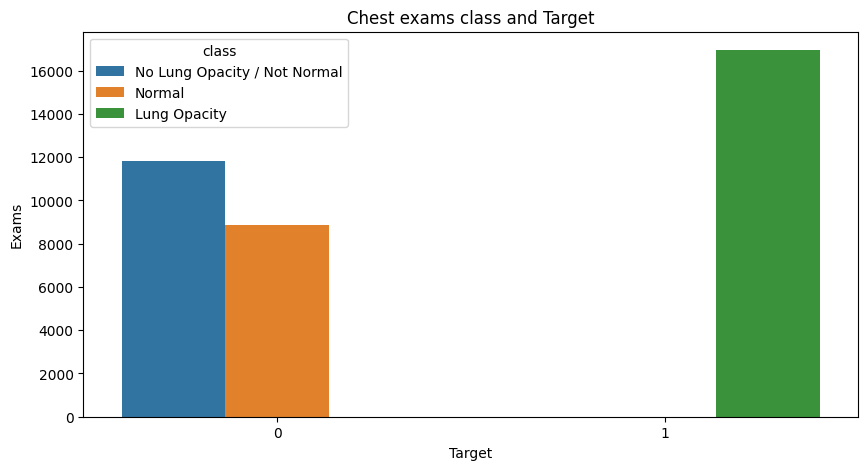

In [191]:
fig, ax = plt.subplots(nrows=1,figsize=(10,5))
tmp = df.groupby('Target')['class'].value_counts()
temp_df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Exams',hue='class',data=temp_df, palette=color)
plt.title("Chest exams class and Target")
plt.show()

### Funtion to print the data images with bbox(if any)

In [125]:
class_str = list(data_class.keys())

def print_sample(sample_images, rows, columns):

    fig, axes = plt.subplots(rows, columns, figsize=(9, 9))
    axes = axes.flatten() # flatten the axis form 2D to 1D making it easier to index over it

    total_subplots = rows * columns

    for idx in range(min(len(sample_images), total_subplots)): # Limit the display to just rows*columns images
        row = sample_images.iloc[idx]
        Id = row.patientId
        class_label = row.Target
        dcm_file_path = f'data/pneumonia_dataset/stage_2_train_images/{Id}.dcm'
        dcm_file_data = dcmread(dcm_file_path)
        pixel_data = dcm_file_data.pixel_array
        
        axes[idx].imshow(pixel_data, cmap='grey')
        axes[idx].axis(False)

        # Print Bounding Box if the pneumonia present
        if class_label == 1:
            x, y, width, height, =  row.x, row.y, row.width, row.height
            rect = Rectangle((x, y), width, height, facecolor='none', edgecolor='red', lw=2)
            axes[idx].add_patch(rect)

        # Set Title color according to class
        color = 'green' if class_label == 0 else 'red'
        # Set titel to the patient Id and the status of the present of pneumonia or not
        # axes[idx].set_title(f'Patient Id: {Id}, {class_label}', fontsize=9, color=color)
        axes[idx].set_title(f'{class_str[class_label]}', fontsize=12, color=color)

    plt.tight_layout()

    # Hide any unused subplots
    for j in range(len(sample_images), total_subplots):
        axes[j].axis('off')

### Print some of the pneumonia and no pneumonia images form the dataset

In [126]:
pneu_df = df[df.Target == 1]
no_pneu_df = df[df.Target == 0]

pneu_present_sample = pneu_df.sample(9)
pneu_not_present_sample = no_pneu_df.sample(9)

# all_class_sample = pd.concat([pneu_present_sample, pneu_not_present_sample])

# all_class_sample = all_class_sample.sample(frac=1)

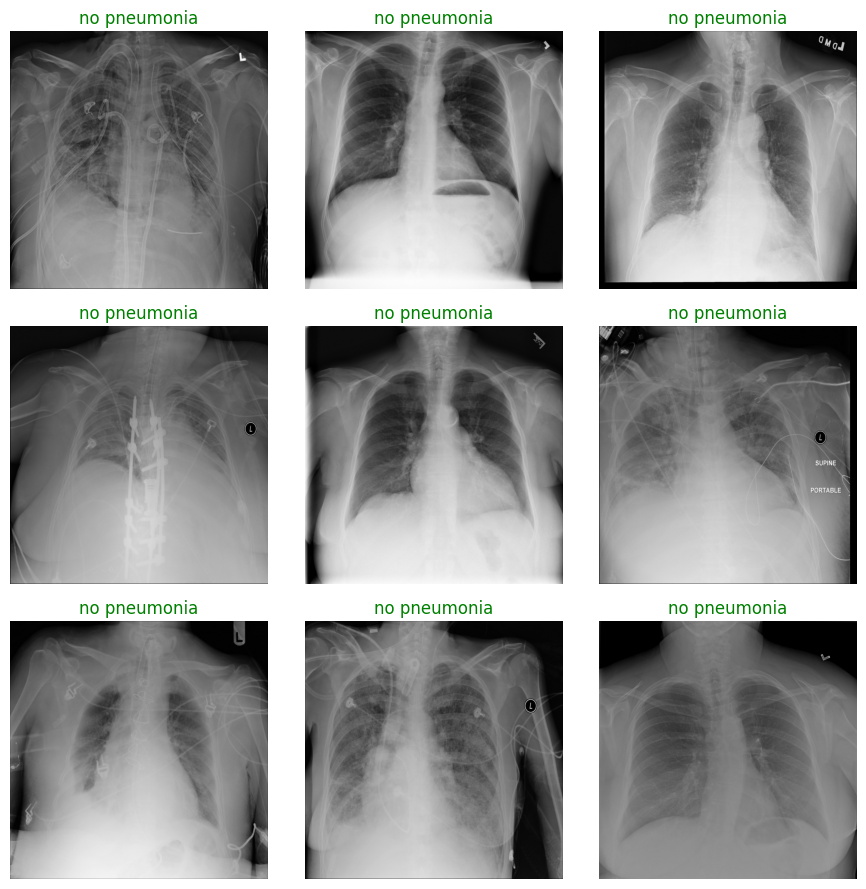

In [128]:
# No Pneumonia Present samples
print_sample(pneu_not_present_sample, rows=3, columns=3)

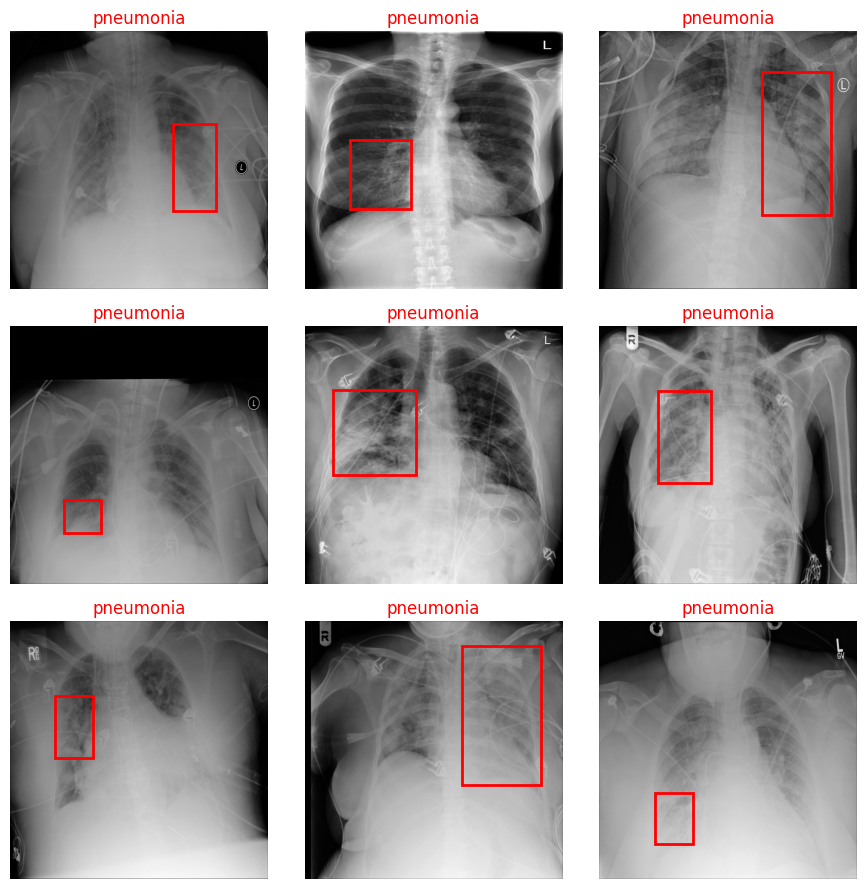

In [129]:
# Pneumonia Present Samples
print_sample(pneu_present_sample, rows=3, columns=3)

### Check the distribution of disease(for case that have pneumonia) by Age and Sex
### Then Plot a histogram to show the distribtuion across these Variables(age and sex)
Try a bunch of range for the histogram for the proper insight
(Refer to the statQuest Histogram video if confused about the Histogram)

In [198]:
import timeit

age = []
sex = []
for index, Id in enumerate(df.patientId):
    dcm_file_path = f'data/pneumonia_dataset/stage_2_train_images/{Id}.dcm'
    dcm_file = dcmread(dcm_file_path, stop_before_pixels=True)

    print(index)

    # patient_age = int(dcm_file.PatientAge)
    # patient_sex = dcm_file.PatientSex
    
    # age.append(patient_age)
    # sex.append(patient_sex)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [66]:
df['age'] = age
df['sex'] = sex

In [193]:
df

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
...,...,...,...,...,...,...,...
37624,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,Normal
37625,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity
37626,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity
37627,c1f7889a-9ea9-4acb-b64c-b737c929599a,233.0,424.0,201.0,356.0,1,Lung Opacity


In [72]:
df.sex.value_counts()

sex
M    17216
F    13011
Name: count, dtype: int64

In [59]:
age_histogram_data = df.drop_duplicates('patientId').age

<Axes: xlabel='age', ylabel='Count'>

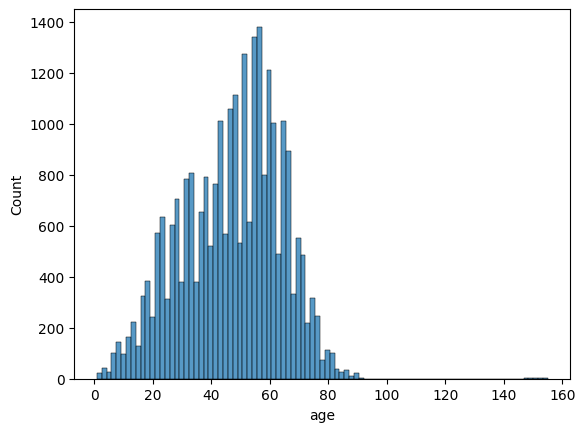

In [60]:
sns.histplot(age_histogram_data)

0        51
1        48
2        19
3        28
4        32
         ..
30219    47
30221    54
30223    46
30224    45
30225    72
Name: age, Length: 26684, dtype: int64

### Normalize the bbox coordinates in the dataframe

### Data Augmentation

### Address the Class Imbalance

### SPlit the Data into Train and Val Set and Test Set..... 
### Format the data to pass into the YOLOv8

In [79]:
# Get all the uniques Id of the data
uniques_Id = df.patientId.unique()


# Split these Id into either of the train or val set
from sklearn.model_selection import train_test_split

train_Id, val_Id = train_test_split(uniques_Id, train_size=0.8, test_size=0.2)

print(f'YOLO Train Data Samples: {len(train_Id)}')
print(f'YOLO val Data Samples: {len(val_Id)}')

YOLO Train Data Samples: 21347
YOLO val Data Samples: 5337


In [84]:
# Since the original data is imbalanced check how the data is spread out (the classes) in the train and validation set

# Take these train and val split Id and split the dataset based on these id into train dataset and val dataset
train = df[df['patientId'].isin(train_Id)]
val = df[df['patientId'].isin(val_Id)]

# The distribution of two classes in the train data
print(train.drop_duplicates('patientId').Target.value_counts())

# The distribution of two classes in the val data
print(val.drop_duplicates('patientId').Target.value_counts())

Target
0    16548
1     4799
Name: count, dtype: int64
Target
0    4124
1    1213
Name: count, dtype: int64


In [7]:
# Get all the train data samples and test data samples path as list
# `train_path` will be list of data path(with labels file)

# `test_path` which are data path (with no labels file) will be used to test the model after the training and validation is completed

data_file = Path('data/pneumonia_dataset')

train_path = list(data_file.glob('stage_2_train_images/*.dcm'))
test_path = list(data_file.glob('stage_2_test_images/*.dcm'))
print(f'Train Data Images: {len(train_path)}')
print(f'Test Data Images: {len(test_path)}')

Train Data Images: 26684
Test Data Images: 3000


In [8]:
train.drop_duplicates('patientId')


# take each column and index the id...seach for the image with that id and then donwload the image and save it in the proper path

,patientId,x,y,width,height,Target
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...
30219,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,666.0,418.0,186.0,223.0,1
30221,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,609.0,464.0,240.0,284.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0


In [ ]:
data = dcmread(train_path[0])
pixel_data = data.pixel_array
image = Image.fromarray(pixel_data)
image.save('./scan.jpg')

Text(0.5, 1.0, 'Bounding Box HeatMap Overlay')

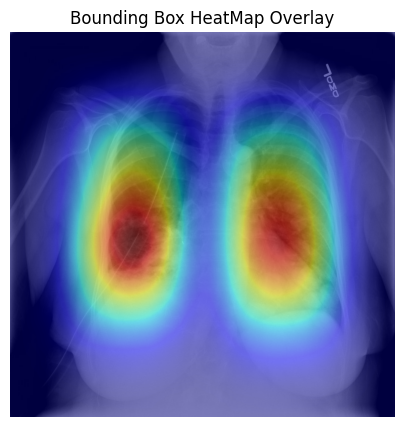

In [124]:
# Get all the labeled data rows (Target = 1) and plot the bbox into the heatmap

# get all the columns data with the bounding box values
target_data = df[df.Target == 1]
bbox_data = target_data.iloc[:, 1: 5]
bbox_data

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your image
image = cv2.imread('scan.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create an empty heatmap (same height and width as image)
heatmap = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)

for index, box in bbox_data.iterrows():
    x, y, w, h = box
    x_min, y_min = int(x), int(y)
    x_max, y_max = int(x + w), int(y + h)
    
    # Add 1 to the heatmap area covered by this bbox
    heatmap[y_min:y_max, x_min:x_max] += 1


# Normalize heatmap to 0-1
heatmap /= np.max(heatmap)

# Optional: apply Gaussian blur for smoothness
heatmap = cv2.GaussianBlur(heatmap, (31,31), 0)

plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.axis(False)
plt.title('Bounding Box HeatMap Overlay')

In [ ]:
# Take the model we have trained now(the best one).....run inference on it and get the return bbox data from it....and plot the heatmap...the heatmap of our trained model (map50 = 0.25) on the final prediciton of the model

# For post model evaluation heatmap

# Only add to the heatmap when the confiednce score in greater then a ceratin threshold
# if confidence_score > threshold:
    # .....
    # .....
    # heatmap[y_min:y_max, x_min:x_max] += 1

# Also dont add 1 but rather add the confidence score
# if confidence_score > threshold:
    # .....
    # .....
    # heatmap[y_min:y_max, x_min:x_max] += confidence_score



# Why we add a confidence score......

# If you just add +1 for every predicted box above the threshold, all boxes are treated equally — even if one is 51% confident and another is 99%. But intuitively:

# A 99% confidence box should contribute more to the heatmap.

# A 51% confidence box might be a borderline false positive — it should contribute less.

# By adding the confidence score:

# Areas where the model consistently predicts with high confidence will "light up" more.

# You get a more nuanced and informative visualization.

In [ ]:
from pydicom import dcmread
dcmread(test_path[0])

In [ ]:
# Check if neumonia cases vary by metadata like (age, sex, image view) and plot graphs


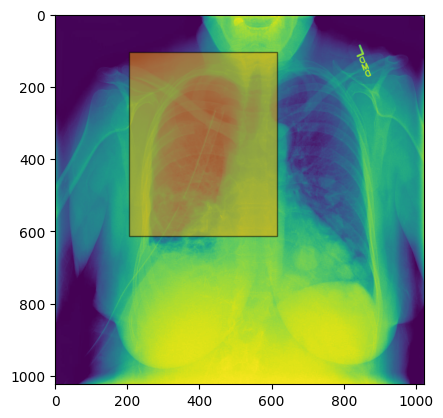

In [76]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots()


image = Image.open('scan.jpg')
plt.imshow(image)

# Rectangle in axes coordinates (0–1 range)
rect = patches.Rectangle((0.2, 0.4), 0.4, 0.5,
                         transform=ax.transAxes,
                         facecolor='orange', edgecolor='black', alpha=0.5)

ax.add_patch(rect)
plt.show()

In [10]:
def dcm_to_jpg(dcm_path, save_path):
    '''
    Convert a DICOM (.dcm) file to a JPEG (.jpg) file and save it.

    This function reads a DICOM file from `dcm_path`, converts the pixel data
    to an image, and saves the image as a JPEG file at `save_path`.

    Args:
        dcm_path (str): File path of the input DICOM file.
        save_path (str): File path to save the output JPEG file.

    Returns:
        None
    '''
    save_path = Path(save_path)

    if not save_path.is_dir():
        dcm_data = dcmread(dcm_path)
        dcm_pixel_array = dcm_data.pixel_array
        image = Image.fromarray(dcm_pixel_array)
        image.save(save_path, 'JPEG')


In [11]:
# Create YOLO File format list

yolo_file_format = ['YOLO_format_data', ['images', 'labels', 'data.yaml'], ['train', 'val']]

# Create the YOLO file format directory
for x in range(2):
    for y in range(2):
        form_path = os.path.join(yolo_file_format[0], yolo_file_format[1][x], yolo_file_format[2][y])
        form_path = Path(form_path)
        form_path.mkdir(parents=True, exist_ok=True)

# # Create data.yaml file
yaml_file = Path(yolo_file_format[0]) / yolo_file_format[1][2]

# Content for the data.yaml file as required by the YOLO model
yaml_content = {
    'train': f'{yolo_file_format[1][0]}/{yolo_file_format[2][0]}',
    'val': f'{yolo_file_format[1][0]}/{yolo_file_format[2][1]}',
    'nc': 1,
    'names': ['pneumonia']
}

# write the content into the data.yaml file
with open(yaml_file, 'w') as file:
    yaml.dump(yaml_content, file)

In [12]:
# Save all the training images into the images direcotry

train_image_name_list = []
for x in range(len(yolo_train_path)):
    img = f'img{x+1}.jpg'
    train_image_name_list.append(img)

train_yolo_img = Path('YOLO_format_data/images/train')



for index, path in enumerate(yolo_train_path):
    save_path = os.path.join(train_yolo_img, train_image_name_list[index])
    dcm_to_jpg(dcm_path=path, save_path=save_path)



In [13]:
# Save all the val images into the val directory

val_image_name_list = []
cont = len(train_image_name_list)
cont
for x in range(len(val_path)):
    img = f'img{cont+x+1}.jpg'
    val_image_name_list.append(img)

val_yolo_img = Path('YOLO_format_data/images/val')

for index, path in enumerate(val_path):
    save_path = os.path.join(val_yolo_img, val_image_name_list[index])
    dcm_to_jpg(dcm_path=path, save_path=save_path)

In [14]:
# File path of the labels from the working data and convert the csv file into a pandas DataFrame

label_file_path = 'data/pneumonia_dataset/stage_2_train_labels.csv'
label_csv = pd.read_csv(label_file_path)
label_csv

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


In [15]:
# Create a list of all the txt files names for train labels file

train_image_txt_list = []

for image_name in train_image_name_list:
    image_name = Path(image_name)
    name = image_name.stem
    txt_fil_name = f'{name}.txt'
    train_image_txt_list.append(txt_fil_name)

In [16]:
# File path to save the train labels file to
labels_train = Path('YOLO_format_data/labels/train')


# Iterate over each path from the list of training data path
for index, path in enumerate(yolo_train_path):

    # Patient Id of the instance of data 
    id = path.stem
    # Get all the label data associated with the Id
    bbox_data = label_csv[label_csv['patientId'] == id] 

    # final file path to save the instance of label data to
    labels_train_txt = os.path.join(labels_train, train_image_txt_list[index])

    # Create a  label file for each image data
    with open(labels_train_txt, 'w') as f:
        # write label into the file if the bbox for the image exists 
        if bbox_data.iloc[0, 5].item() == 1:
            label_class_id = bbox_data.iloc[0, 5].item()
            for x in range(len(bbox_data)):
                x1 = bbox_data.iloc[x, 1].item() / 1024
                y1 = bbox_data.iloc[x, 2].item() / 1024
                width = bbox_data.iloc[x, 3].item() / 1024
                height = bbox_data.iloc[x, 4].item() / 1024
                f.write(f'{label_class_id-1} {x1} {y1} {width} {height}')
                f.write('\n')
        # Write nth into the file if no bbox for the instance of data exist
        else:
            pass

In [17]:
# Create a list of all the txt files names for val labels file

val_image_txt_list = []

for image_name in val_image_name_list:
    image_name = Path(image_name)
    name = image_name.stem
    txt_fil_name = f'{name}.txt'
    val_image_txt_list.append(txt_fil_name)

In [18]:
labels_val = Path('YOLO_format_data/labels/val')

x = 0
for index, path in enumerate(val_path):
    id = path.stem
    bbox_data = label_csv[label_csv['patientId'] == id]

    labels_train_txt = os.path.join(labels_val, val_image_txt_list[index])

    with open(labels_train_txt, 'w') as f:
        if bbox_data.iloc[0, 5].item() == 1:
            label_class_id = bbox_data.iloc[0, 5].item()
            for x in range(len(bbox_data)):
                x1 = bbox_data.iloc[x, 1].item() / 1024
                y1 = bbox_data.iloc[x, 2].item() / 1024
                width = bbox_data.iloc[x, 3].item() / 1024
                height = bbox_data.iloc[x, 4].item() / 1024
                f.write(f'{label_class_id-1} {x1} {y1} {width} {height}')
                f.write('\n')
        # Write nth into the file if no bbox for the instance of data exist
        else:
            pass

    # break
    

# Workign with the data part is done...now fine tuning the model part


In [19]:
from ultralytics import YOLO

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
model = YOLO('yolov8n.pt')

In [ ]:
train_results = model.train(
    data='YOLO_format_data/data.yaml',
    epochs=5,
    imgsz=640,
    batch=16,
    name='medical_imaging'
)

In [ ]:
# Cheked one image of the data and it was in shape of 1024*1024 so a loop to check if all the image are also in 1024*1024 or not

# len(yolo_train_path)
# x = dcmread(yolo_train_path[3])
# shape = x.pixel_array.shape
# for x in shape:
#     print(x)


# for index, path in enumerate(yolo_train_path):
#     data = dcmread(path)
#     image_shape = data.pixel_array.shape
#     for x in image_shape:
#         if x != 1024:
#             print(index)
#             break

1024
1024


In [162]:
from ultralytics import YOLO

# # Instanciate a new training 
# model = YOLO('runs/detect/medical_imaging_v4/weights/best.pt')
# model.train(data='YOLO_format_data/data.yaml', epochs=50, project='runs/detect', name='medical_imaging_50_epo')


# Continue Training
model = YOLO('runs/detect/medical_imaging_50_epo/weights/last.pt')
# model.train(resume=True)

In [163]:
model.val()

Ultralytics 8.3.146  Python-3.12.3 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


FileNotFoundError: 'YOLO_format_data/data.yaml' does not exist